In [1]:
import numpy as np
import pandas as pd

from apyori import apriori
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.font_manager import FontProperties

from datetime import datetime
import en_nlp_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-29 16:28:13.300166


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

df_review:
source                       0
hotel_id                     0
hotel_name                   0
country                      0
group_name                   0
room_type                    0
stay_length                  0
stay_date                    0
review_score                 0
review_score_category        0
sentiment                    0
review_date                  0
review_title                 1
review                       0
review_cleaned_v1            0
ADJ                       4706
ADV                      19609
NOUN                      2643
VERB                     12652
PROPN                    25027
DET                      38265
NUM                      36267
dtype: int64
Total rows in df_review: 39831 



## 1) Association Rule Mining

### a) Helper functions

In [4]:
# Function to convert the input value of a string type to a list of words
def process_all_words(value):
    if isinstance(value, str):
        return value.split()
    return []


# Function to discover association rules between item sets in a data set
# and to represent these rules as a graphical network for visualization
def find_association_rules(target_text, min_support=0.01, min_confidence=0.3, min_lift=3, min_length=2):
    
    # Process target_text: split each string into a list of words
    text = target_text.apply(process_all_words)
    text = [x for x in text if x != []]  # Remove empty lists
    
    # Find association rules using Apriori algorithm
    association_rules = apriori(text, min_support=min_support, min_confidence=min_confidence, 
                                min_lift=min_lift, min_length=min_length)
    association_results = list(association_rules)
    
    # Initialize a directed graph
    G = nx.DiGraph()
    
    # Summarize association rules and add edges to the graph
    rules_summary = [{
        "antecedent": list(item[2][0][0]),
        "consequent": list(item[2][0][1]),
        "support": round(item[1], 4),
        "confidence": round(item[2][0][2], 4),
        "lift": round(item[2][0][3], 4),
    } for item in association_results]
    
    print(f"Success. {len(rules_summary)} rules found.")
    print("========================================")
    
    # Print and add edges to the graph
    for rule in rules_summary:
        print(f"Rule: {rule['antecedent']} => {rule['consequent']}")
        print("Support: " + str(rule["support"]))
        print("Confidence: " + str(rule["confidence"]))
        print("Lift: " + str(rule["lift"]))
        print("----------------------------------------")
        
        # Add edges to the graph
        for ant in rule["antecedent"]:
            for con in rule["consequent"]:
                G.add_edge(ant, con, weight=rule["lift"], support=rule["support"], confidence=rule["confidence"])

    # Check if there are any edges to plot
    edges = G.edges(data=True)
    if not edges:
        print("No edges to plot. Exiting visualization.")
        return
    
    # Create a custom colormap
    colors = plt.cm.Blues(np.linspace(0.5, 1, 256))
    new_cmap = LinearSegmentedColormap.from_list("new_blues", colors)
    
    # Draw the network graph
    pos = nx.spring_layout(G, k=1, iterations=15)  # Adjust layout parameters for a more compact graph
    plt.figure(figsize=(12, 12))  # Increase figure size for better visibility
    
    # Node color and size
    node_color = "skyblue"
    node_size = 3000
    
    # Edge width and color
    edge_color = [d["weight"] for (u, v, d) in edges]
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    
    # Function to shorten edges to prevent overlap with nodes
    def shorten_edge(pos, src, dst, shrink_factor=0.1):
        """Shorten edges to prevent overlap with nodes"""
        x1, y1 = pos[src]
        x2, y2 = pos[dst]
        new_x2 = x1 + (x2 - x1) * (1 - shrink_factor)
        new_y2 = y1 + (y2 - y1) * (1 - shrink_factor)
        return (x1, y1), (new_x2, new_y2)
    
    new_edges = []
    for src, dst, data in edges:
        new_edges.append((*shorten_edge(pos, src, dst), data))
    
    # Draw edges with shortened positions
    for ((x1, y1), (x2, y2), data) in new_edges:
        plt.arrow(x1, y1, x2 - x1, y2 - y1, color=new_cmap(Normalize(vmin=min(edge_color), 
                                                                     vmax=max(edge_color))(data["weight"])),
            alpha=0.8, head_width=0.05, head_length=0.1, length_includes_head=True, width=0.01)
        # Show lift value at the midpoint of the edge
        plt.text((x1 + x2) / 2, (y1 + y2) / 2, f"{data['weight']:.2f}", fontsize=10, 
                 horizontalalignment="center", verticalalignment="center")

    # Draw labels with specified font
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=12, horizontalalignment="center", verticalalignment="center")
    
    # Adjust color mapping for better visibility of the lightest color
    norm = Normalize(vmin=min(edge_color), vmax=max(edge_color))
    sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca())
    
    plt.title("Association Rules Network")
    plt.show()

### b) Find association using whole cleaned reviews

Length of df_review: 39831
Length of df_target_text: 39831
Success. 19 rules found.
Rule: ['bottle'] => ['water']
Support: 0.0108
Confidence: 0.8745
Lift: 15.4397
----------------------------------------
Rule: ['buffet'] => ['breakfast']
Support: 0.0108
Confidence: 0.834
Lift: 10.3354
----------------------------------------
Rule: ['distance'] => ['walk']
Support: 0.0328
Confidence: 0.8982
Lift: 9.8776
----------------------------------------
Rule: ['highly'] => ['recommend']
Support: 0.016
Confidence: 0.9165
Lift: 14.1062
----------------------------------------
Rule: ['swim'] => ['pool']
Support: 0.0145
Confidence: 0.9539
Lift: 17.1917
----------------------------------------
Rule: ['clean', 'stop'] => ['bus']
Support: 0.0103
Confidence: 0.8468
Lift: 15.9473
----------------------------------------
Rule: ['hotel', 'stop'] => ['bus']
Support: 0.0145
Confidence: 0.8182
Lift: 15.4085
----------------------------------------
Rule: ['location', 'stop'] => ['bus']
Support: 0.0139
Confidenc

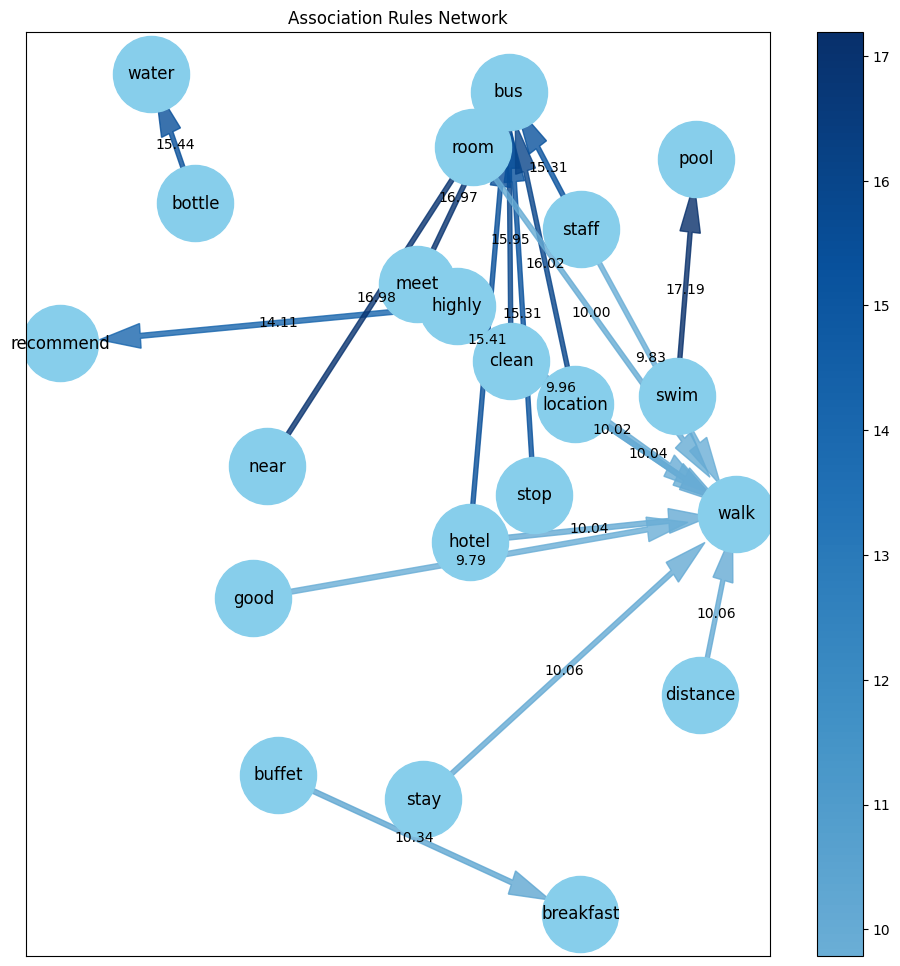

In [5]:
target_text = "review_cleaned_v1"

# Remove rows when target_text is NULL
df_target_text = df_review.dropna(subset=[target_text]).reset_index(drop=True)
print(f"Length of df_review: {len(df_review)}")
print(f"Length of df_target_text: {len(df_target_text)}")

# Find association
find_association_rules(df_target_text[target_text], 0.01, 0.8, 5)

### c) Find association using words by POS tagging

Length of ADJ: 35125
Success. 13 rules found.
Rule: ['bare'] => ['long']
Support: 0.0012
Confidence: 0.4667
Lift: 22.3624
----------------------------------------
Rule: ['male'] => ['female']
Support: 0.0008
Confidence: 0.4154
Lift: 108.8835
----------------------------------------
Rule: ['sleeper'] => ['light']
Support: 0.0005
Confidence: 0.5294
Lift: 66.8906
----------------------------------------
Rule: ['overall', 'cold'] => ['hot']
Support: 0.0006
Confidence: 0.44
Lift: 19.4647
----------------------------------------
Rule: ['spacious', 'cold'] => ['hot']
Support: 0.0005
Confidence: 0.5
Lift: 22.119
----------------------------------------
Rule: ['comfortable', 'public'] => ['easy']
Support: 0.0008
Confidence: 0.4219
Lift: 12.2466
----------------------------------------
Rule: ['good', 'cold', 'clean'] => ['hot']
Support: 0.0009
Confidence: 0.5246
Lift: 23.2068
----------------------------------------
Rule: ['great', 'good', 'cold'] => ['hot']
Support: 0.0005
Confidence: 0.5455
Li

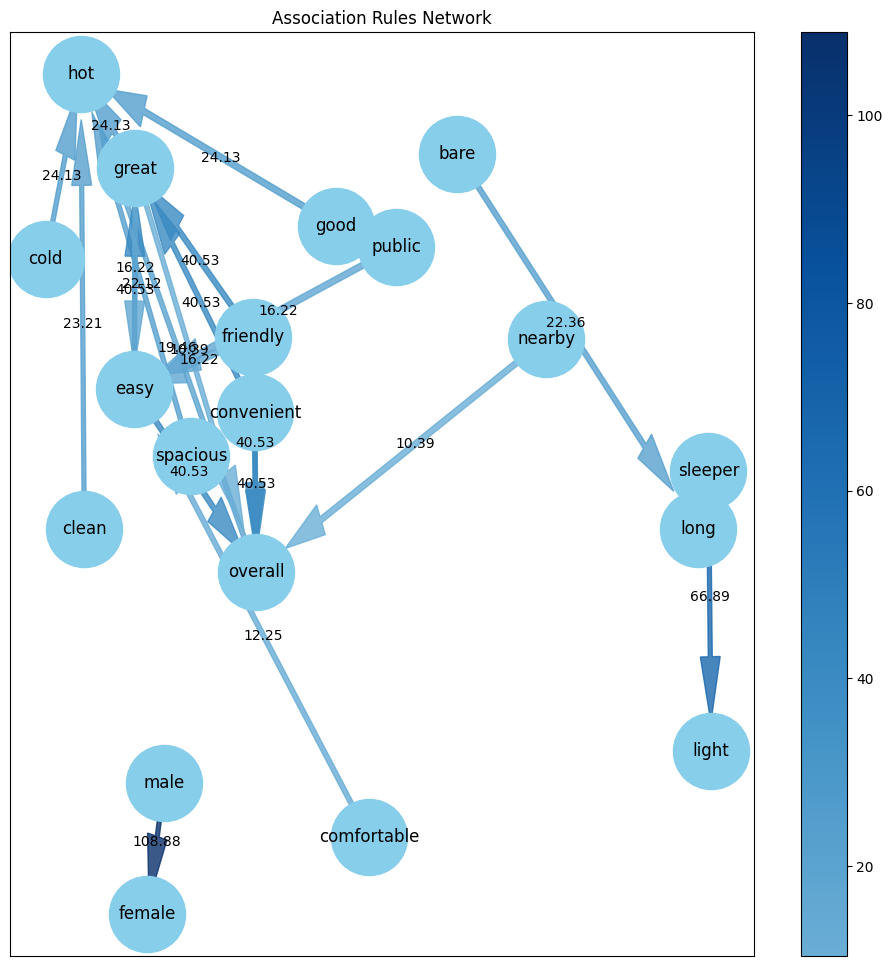

In [6]:
# Remove rows when "ADJ" is NULL
df_tag = df_review.dropna(subset=["ADJ"]).reset_index(drop=True)
print(f"Length of ADJ: {len(df_tag)}")

# Find association
find_association_rules(df_tag["ADJ"], 0.0005, 0.4, 10)

Length of ADV: 20222
Success. 6 rules found.
Rule: ['forth'] => ['back']
Support: 0.0007
Confidence: 0.9333
Lift: 13.8473
----------------------------------------
Rule: ['bit'] => ['far']
Support: 0.0011
Confidence: 0.5238
Lift: 11.7564
----------------------------------------
Rule: ['somewhere'] => ['else']
Support: 0.002
Confidence: 0.4556
Lift: 32.4375
----------------------------------------
Rule: ['still', 'first'] => ['already']
Support: 0.0005
Confidence: 0.3333
Lift: 18.218
----------------------------------------
Rule: ['also', 'finally'] => ['never']
Support: 0.0005
Confidence: 0.3438
Lift: 12.7313
----------------------------------------
Rule: ['even', 'somewhere'] => ['else']
Support: 0.0005
Confidence: 0.5789
Lift: 41.2235
----------------------------------------


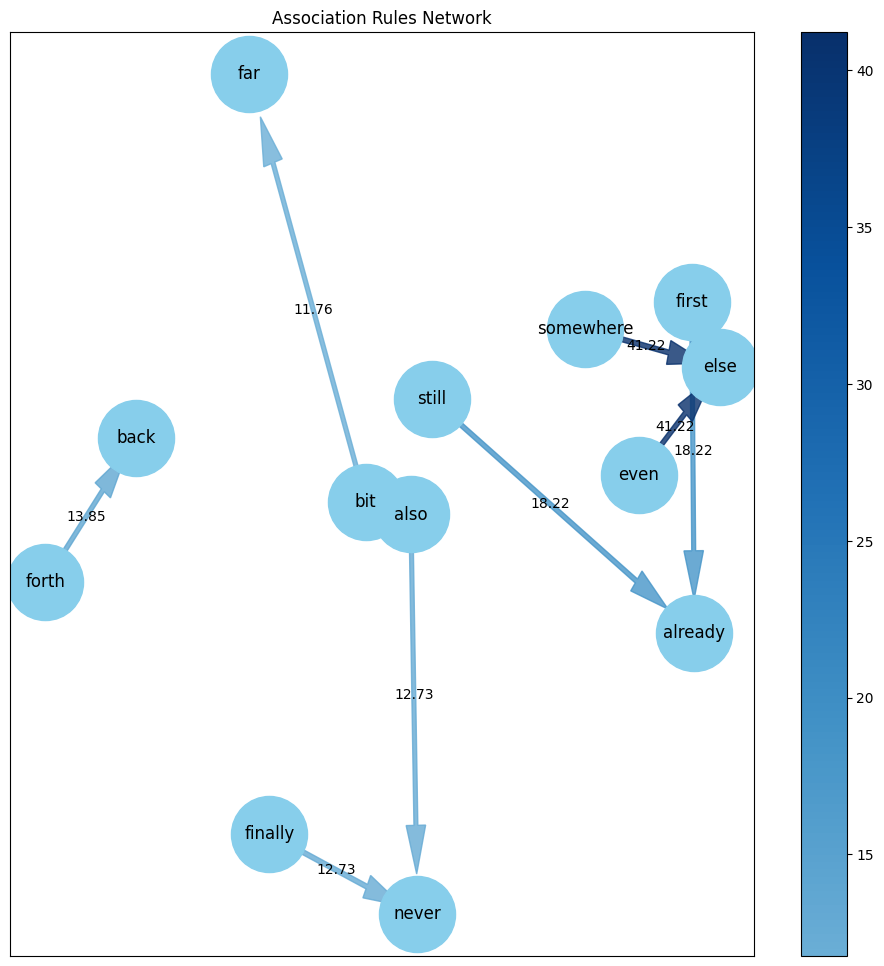

In [7]:
# Remove rows when "ADV" is NULL
df_tag = df_review.dropna(subset=["ADV"]).reset_index(drop=True)
print(f"Length of ADV: {len(df_tag)}")

# Find association
find_association_rules(df_tag["ADV"], 0.0005, 0.3, 10)

Length of NOUN: 37188
Success. 29 rules found.
Rule: ['bottle'] => ['water']
Support: 0.0109
Confidence: 0.8785
Lift: 14.8166
----------------------------------------
Rule: ['bus'] => ['station']
Support: 0.025
Confidence: 0.4406
Lift: 5.2371
----------------------------------------
Rule: ['stop'] => ['bus']
Support: 0.0159
Confidence: 0.8326
Lift: 14.7027
----------------------------------------
Rule: ['distance'] => ['walk']
Support: 0.0312
Confidence: 0.7994
Lift: 11.6314
----------------------------------------
Rule: ['meet'] => ['station']
Support: 0.0389
Confidence: 0.5373
Lift: 6.3857
----------------------------------------
Rule: ['minute'] => ['walk']
Support: 0.0124
Confidence: 0.4783
Lift: 6.9584
----------------------------------------
Rule: ['money'] => ['value']
Support: 0.029
Confidence: 0.6358
Lift: 15.6163
----------------------------------------
Rule: ['sleep'] => ['night']
Support: 0.0101
Confidence: 0.3339
Lift: 4.1338
----------------------------------------
Rule: 

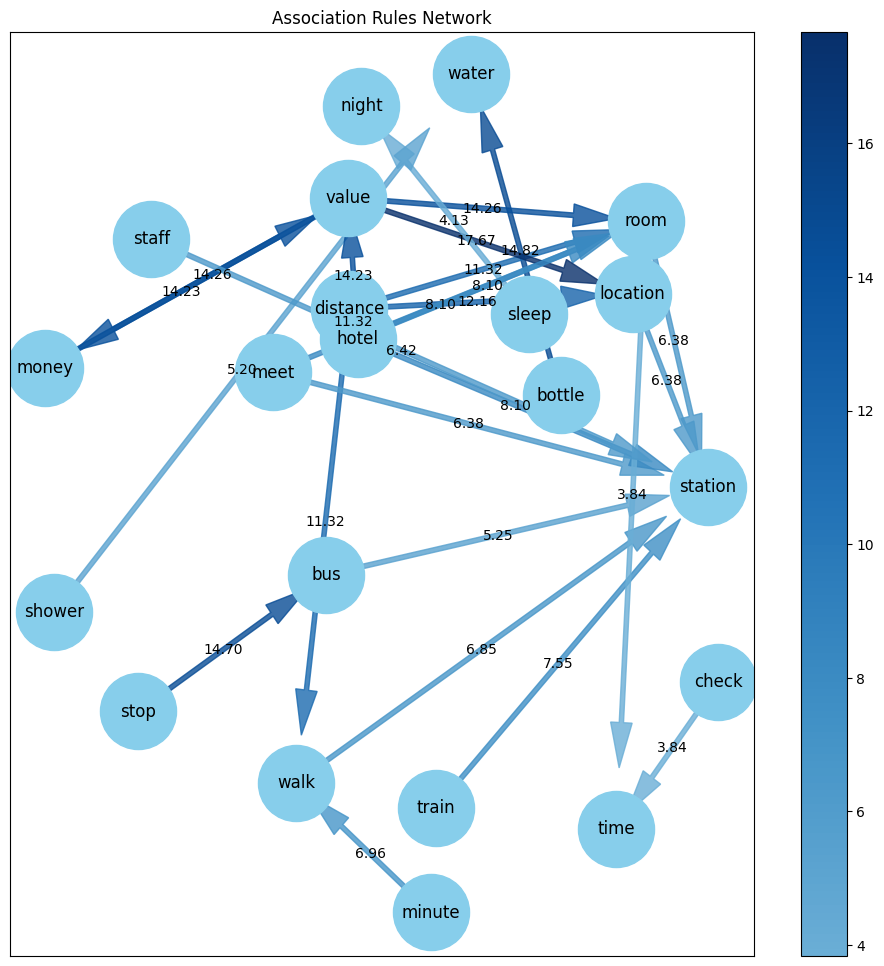

In [8]:
# Remove rows when "NOUN" is NULL
df_tag = df_review.dropna(subset=["NOUN"]).reset_index(drop=True)
print(f"Length of NOUN: {len(df_tag)}")

# Find association
find_association_rules(df_tag["NOUN"])

Length of VERB: 27179
Success. 20 rules found.
Rule: ['pick', 'ask'] => ['say']
Support: 0.0006
Confidence: 0.7143
Lift: 20.3071
----------------------------------------
Rule: ['take', 'call', 'ask'] => ['tell']
Support: 0.0005
Confidence: 0.6364
Lift: 31.9699
----------------------------------------
Rule: ['check', 'say', 'keep'] => ['ask']
Support: 0.0005
Confidence: 0.9333
Lift: 24.3446
----------------------------------------
Rule: ['check', 'call', 'come'] => ['tell']
Support: 0.0006
Confidence: 0.625
Lift: 31.399
----------------------------------------
Rule: ['call', 'come', 'wait'] => ['tell']
Support: 0.0005
Confidence: 0.7368
Lift: 37.0178
----------------------------------------
Rule: ['say', 'call', 'get'] => ['tell']
Support: 0.0007
Confidence: 0.6333
Lift: 31.8177
----------------------------------------
Rule: ['call', 'wait', 'get'] => ['tell']
Support: 0.0005
Confidence: 0.6364
Lift: 31.9699
----------------------------------------
Rule: ['call', 'want', 'get'] => ['tel

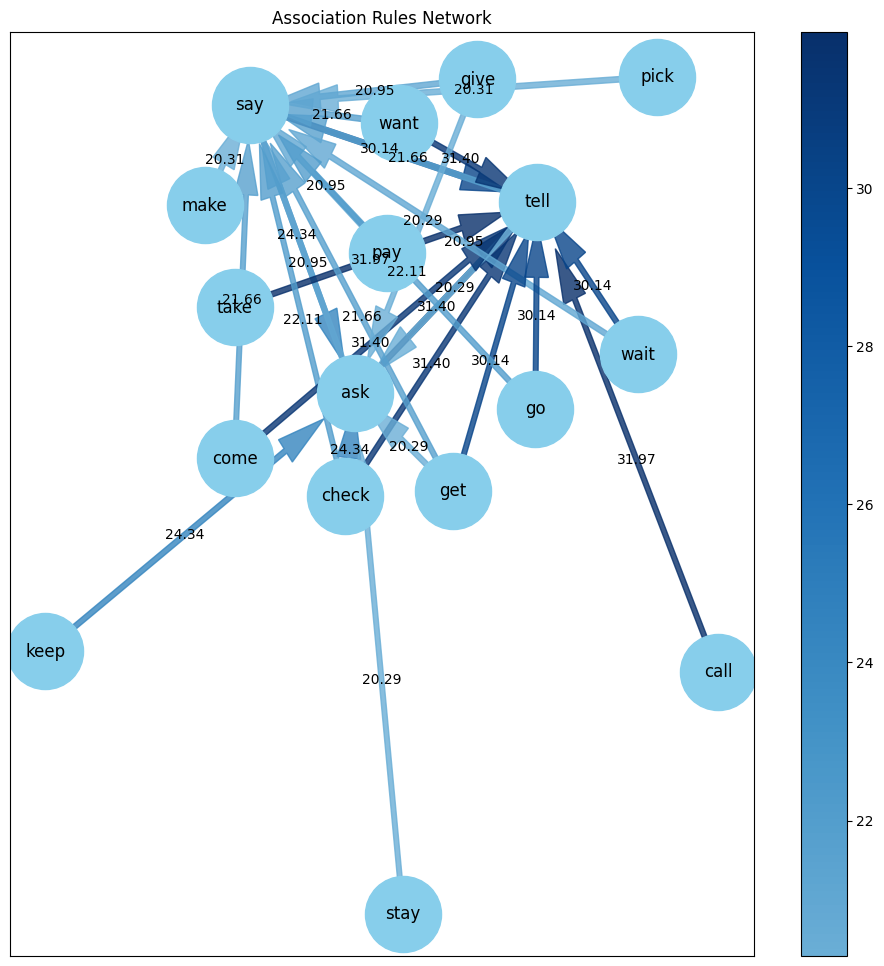

In [9]:
# Remove rows when "VERB" is NULL
df_tag = df_review.dropna(subset=["VERB"]).reset_index(drop=True)
print(f"Length of VERB: {len(df_tag)}")

# Find association
find_association_rules(df_tag["VERB"], 0.0005, 0.6, 20)

Length of PROPN: 14804
Success. 18 rules found.
Rule: ['marina'] => ['bay']
Support: 0.0173
Confidence: 0.8076
Lift: 37.2439
----------------------------------------
Rule: ['sand'] => ['bay']
Support: 0.0041
Confidence: 0.9836
Lift: 45.3623
----------------------------------------
Rule: ['junction'] => ['boris']
Support: 0.0059
Confidence: 0.967
Lift: 25.1599
----------------------------------------
Rule: ['buena'] => ['vista']
Support: 0.0012
Confidence: 1.0
Lift: 528.7143
----------------------------------------
Rule: ['rustle'] => ['bustle']
Support: 0.001
Confidence: 0.8824
Lift: 353.0366
----------------------------------------
Rule: ['town'] => ['china']
Support: 0.0057
Confidence: 0.9655
Lift: 79.4084
----------------------------------------
Rule: ['clarke'] => ['quay']
Support: 0.0062
Confidence: 0.8932
Lift: 57.9956
----------------------------------------
Rule: ['coast'] => ['east']
Support: 0.002
Confidence: 0.8108
Lift: 153.8877
----------------------------------------
Rule

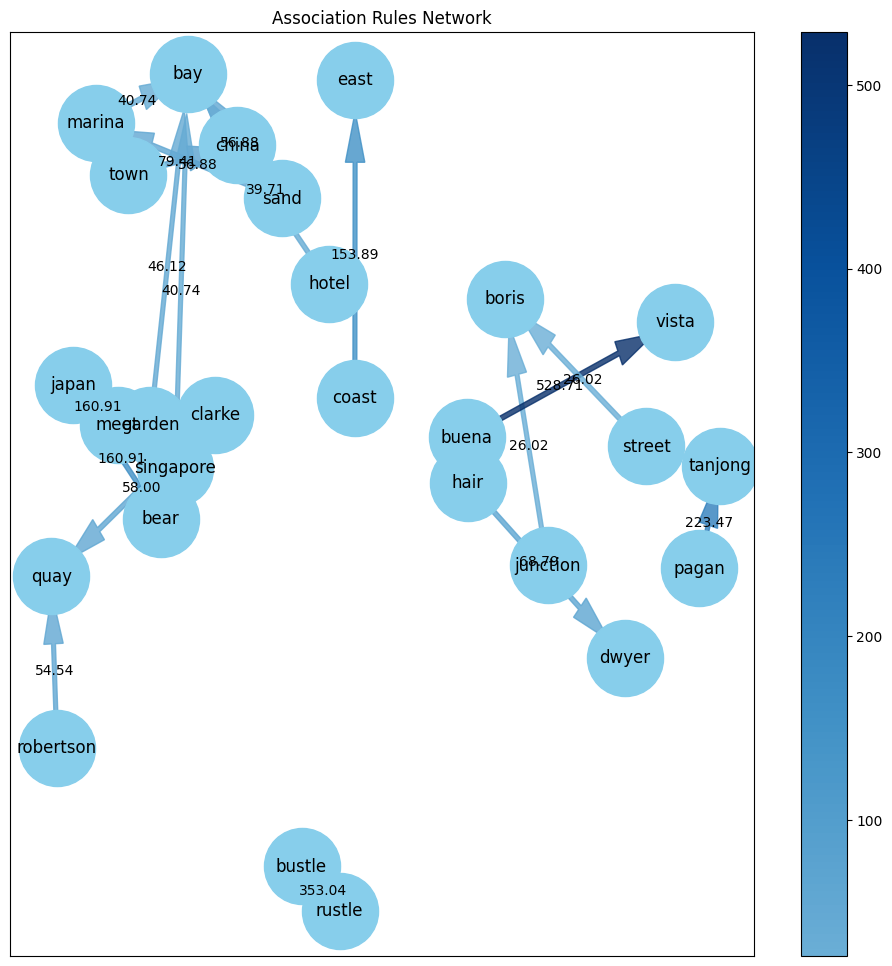

In [10]:
# Remove rows when "PROPN" is NULL
df_tag = df_review.dropna(subset=["PROPN"]).reset_index(drop=True)
print(f"Length of PROPN: {len(df_tag)}")

# Find association
find_association_rules(df_tag["PROPN"], 0.001, 0.8, 20)

Length of DET: 1566
Success. 24 rules found.
Rule: ['bunkthe'] => ['flodedthe']
Support: 0.0006
Confidence: 1.0
Lift: 1566.0
----------------------------------------
Rule: ['bunkthe'] => ['muchthe']
Support: 0.0006
Confidence: 1.0
Lift: 1566.0
----------------------------------------
Rule: ['bunkthe'] => ['toiletsthis']
Support: 0.0006
Confidence: 1.0
Lift: 1566.0
----------------------------------------
Rule: ['everywherethe'] => ['helpfulthe']
Support: 0.0006
Confidence: 1.0
Lift: 1566.0
----------------------------------------
Rule: ['experiencedthe'] => ['informationthe']
Support: 0.0006
Confidence: 1.0
Lift: 1566.0
----------------------------------------
Rule: ['flodedthe'] => ['muchthe']
Support: 0.0006
Confidence: 1.0
Lift: 1566.0
----------------------------------------
Rule: ['flodedthe'] => ['toiletsthis']
Support: 0.0006
Confidence: 1.0
Lift: 1566.0
----------------------------------------
Rule: ['muchthe'] => ['toiletsthis']
Support: 0.0006
Confidence: 1.0
Lift: 1566.0
---

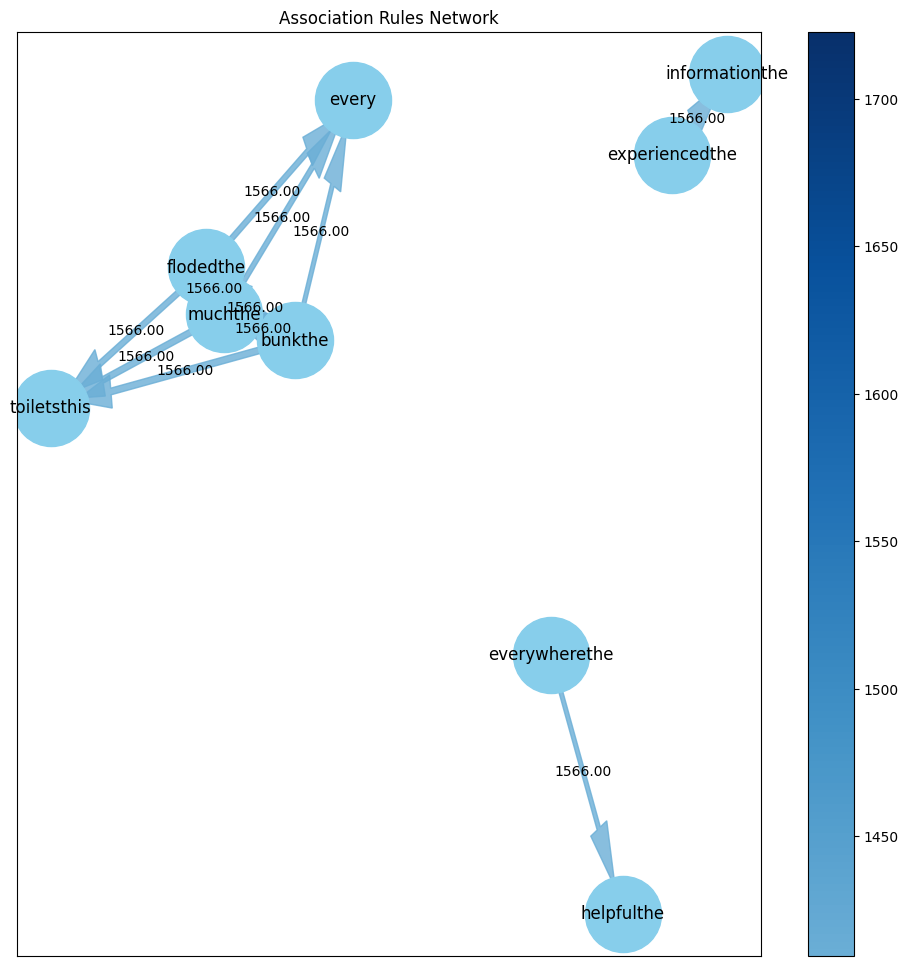

In [11]:
# Remove rows when "DET" is NULL
df_tag = df_review.dropna(subset=["DET"]).reset_index(drop=True)
print(f"Length of DET: {len(df_tag)}")

# Find association
find_association_rules(df_tag["DET"], 0.0005, 0.5, 20)

Length of NUM: 3564
Success. 4 rules found.
Rule: ['seven'] => ['eleven']
Support: 0.0042
Confidence: 0.4054
Lift: 11.0295
----------------------------------------
Rule: ['one', 'seven'] => ['eleven']
Support: 0.0006
Confidence: 0.5
Lift: 13.6031
----------------------------------------
Rule: ['two', 'ten'] => ['four']
Support: 0.0006
Confidence: 1.0
Lift: 34.6019
----------------------------------------
Rule: ['two', 'six'] => ['three']
Support: 0.0006
Confidence: 0.5
Lift: 10.3605
----------------------------------------


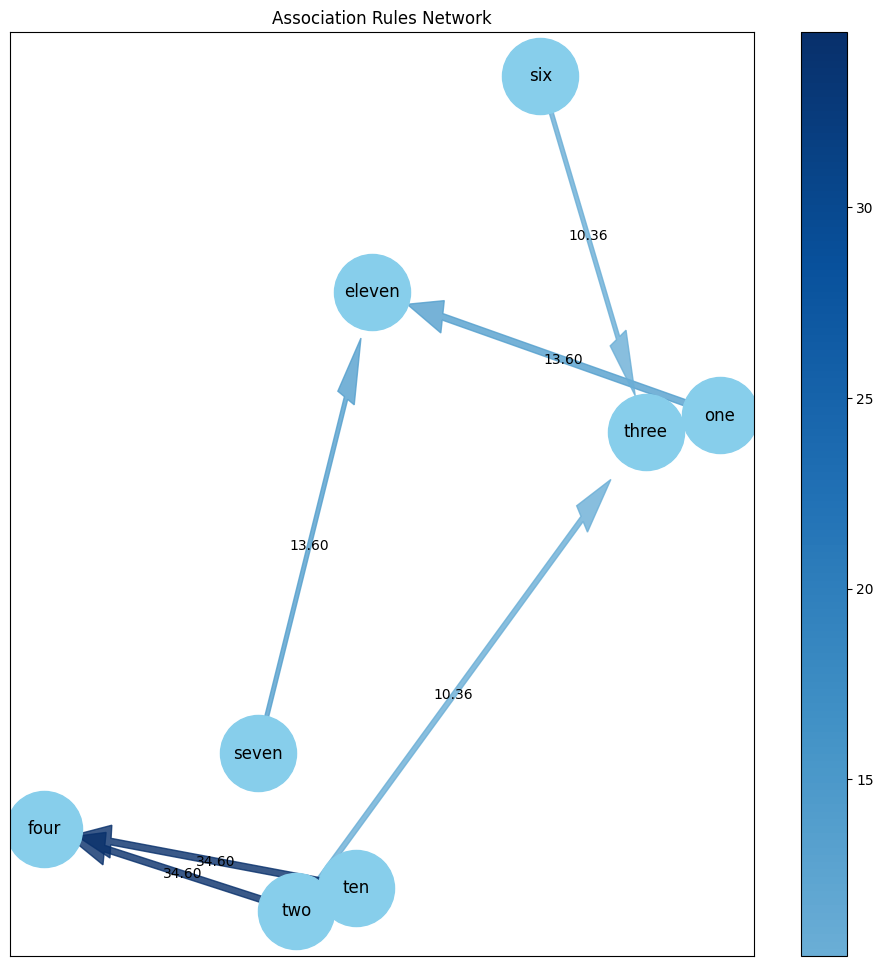

In [12]:
# Remove rows when "NUM" is NULL
df_tag = df_review.dropna(subset=["NUM"]).reset_index(drop=True)
print(f"Length of NUM: {len(df_tag)}")

# Find association
find_association_rules(df_tag["NUM"], 0.0005, 0.3, 10)

In [13]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-29 16:29:27.696346
Text processing spent 0:01:14.396180
